In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
from defermi import DefectsAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='talk',style='whitegrid')


bulk_volume = 800 # A^3
energy_shift = -2

data_dict = [
{'name': 'Vac_O',
  'charge': 2,
  'multiplicity': 1,
  'energy_diff': 7 + energy_shift,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': -2,
  'multiplicity': 1,
  'energy_diff': 8 + energy_shift,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_O',
 'charge':0,
 'multiplicity':1,
 'energy_diff': 10.8 + energy_shift, 
 'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': 0,
  'multiplicity': 1,
  'energy_diff': 7.8 + energy_shift,
  'bulk_volume': bulk_volume},
  ]

df = pd.DataFrame(data_dict)
vbm = 0 # eV
band_gap = 2 # eV
chempots = {'O': -5, 'Sr': -2}
bulk_dos = {'m_eff_e': 0.5, 'm_eff_h': 0.4} # effective masses

da = DefectsAnalysis.from_dataframe(df,band_gap=band_gap,vbm=0)
da.table(display=['energy_diff'])

,name,delta atoms,charge,multiplicity,corrections,energy_diff
0,Vac_O,{'O': -1},0,1,{},8.8
1,Vac_O,{'O': -1},2,1,{},5.0
2,Vac_Sr,{'Sr': -1},-2,1,{},6.0
3,Vac_Sr,{'Sr': -1},0,1,{},5.8


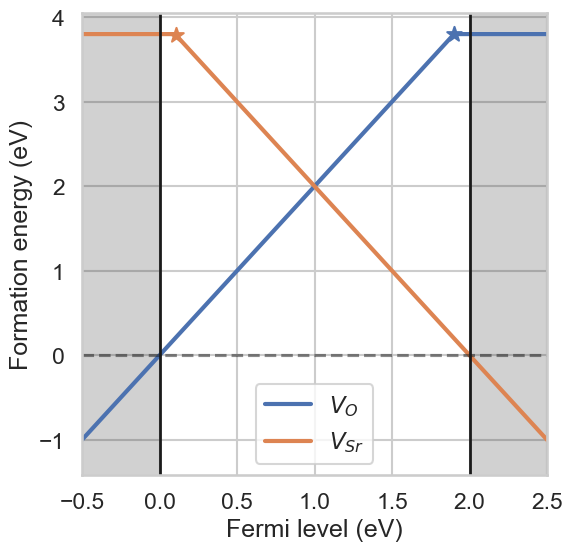

In [36]:
entry = da[1]
eform_bulk = entry.formation_energy(chemical_potentials=chempots)
da.plot_formation_energies(chemical_potentials=chempots);
plt.grid()

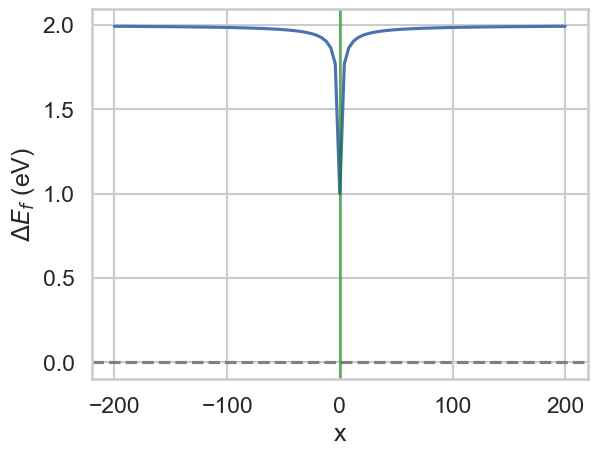

In [37]:
#### FORMATION ENERGIES CUSTOM FUNCTION ####
def formation_energy_interface(
                        entry,
                        vbm=0,
                        chemical_potentials=None,
                        fermi_level=0,
                        temperature=0,
                        x=0):
        
    formation_energy = (entry.energy_diff + entry.charge*(vbm+fermi_level) + 
                    sum([ entry.corrections[correction_type]  for correction_type in entry.corrections ]) 
                    ) 
    
    if chemical_potentials:
        chempot_correction = -1 * sum([entry.delta_atoms[el]*chemical_potentials[el] for el in entry.delta_atoms])
    else:
        chempot_correction = 0
    formation_energy += chempot_correction

    const = 1
    K = 1.1
    shift = -(abs(x) + const)**(-1/K)
    formation_energy += shift
 
    return formation_energy
#########





import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-200,200,101)
Y = [formation_energy_interface(entry,fermi_level=1,chemical_potentials=chempots,x=x) for x in X]
plt.plot(X,Y)
plt.axhline(y=eform_bulk,ls='--',color='grey')
plt.axvline(x=0,color='green',alpha=0.5)
plt.xlabel('x')
plt.ylabel('$\\Delta E_f$ (eV)')
plt.yscale('linear')

In [38]:
da.set_formation_energy_functions(function=formation_energy_interface,name='Vac_O',charge=2)
entry.formation_energy(chemical_potentials=chempots,x=1e10)

-8.111308307159484e-10

In [39]:
da.formation_energies(chempots,x=1)

{'Vac_O': [(0, 3.8000000000000007), (2, -0.5325205447199813)],
 'Vac_Sr': [(-2, 4.0), (0, 3.8)]}

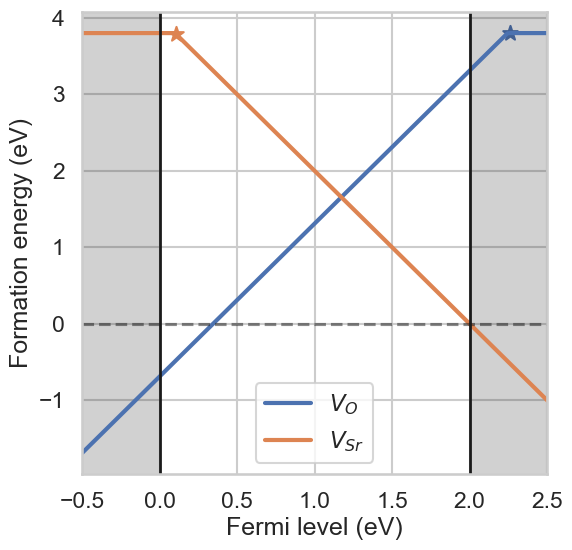

In [40]:
da.plot_formation_energies(chempots,x=0.5)
plt.grid()

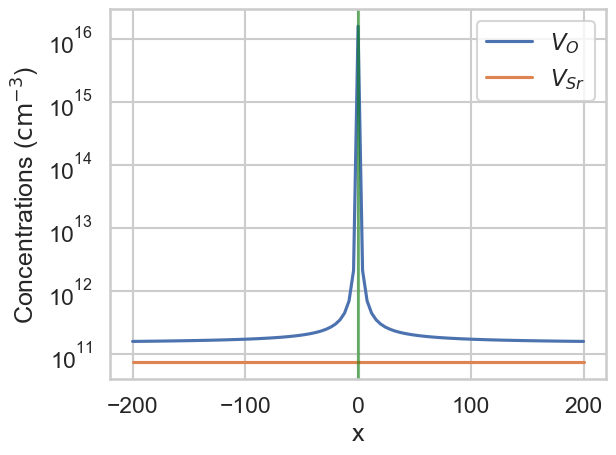

In [41]:
T = 1000
bulk_fermi_level = da.solve_fermi_level(chemical_potentials=chempots,bulk_dos=bulk_dos,temperature=T,eform_kwargs={'x':1e10})

concentrations = []
for x in X:
    eform_kwargs = {'x':x}
    c = da.defect_concentrations(chemical_potentials=chempots,temperature=T,fermi_level=bulk_fermi_level,eform_kwargs=eform_kwargs)
    concentrations.append(c)

Vac_O_conc = [c.total['Vac_O'] for c in concentrations]
Vac_Sr_conc = [c.total['Vac_Sr'] for c in concentrations]

plt.plot(X,Vac_O_conc,label='$V_O$')
plt.plot(X,Vac_Sr_conc,label='$V_{Sr}$')
plt.axvline(x=0,color='green',alpha=0.5)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('Concentrations ($\mathrm{cm}^{-3}$)');
plt.legend();